## Notes for reader

* To install Geopandas (finally...), you probably need to create a new conda environment and install geopandas there.
    * I used the following commands in Anaconda prompt running as admin, on windows: 
        * "conda install -n base nb_conda_kernels"
        * "conda create -n geopandas_env geopandas ipykernel"
            * "geopandas_env" (in the above line)) is just what I named my new environment, you can name it whatever you want
        * Finally, switch the kernel in your Jupyter notebook

## Notes for me

* From *Weather Anomalies...*:
    * "Farm labor is shielded from agricultural losses as we find an almost one-to-one increase in subsidy payments for weather-induced reduction in agricultural yields."
    * During years when agriculture is doing well, non-farm employment is also expanding, while years with bad yields coincide with contractions in non-farm employment
    * **"For counties in the Corn Belt, the MEDIAN FRACTION OF EMPLOYMENT IN AGRICULTURE is 4.6% according to the 2000 decennial Census, based on data from Table QT-P30 of the Census 2000 summary file 3 (factfinder.census.gov)."**
    * "We exclude all counties west of the 100 degree meridian and the state of Florida, as agriculture in those areas is heavily dependent on subsidized irrigation (see Reisner (1993) and Schlenker, Hanemann & Fisher (2005))."
    * We label counties in the following 13 states Corn Belt counties: Illinois, Indiana, Iowa, Kansas, Kentucky, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, and Wisconsin. 16 Counties outside these states that lie east of the 100 degree meridian except Florida are labeled the non-Corn Belt areas
    
* lee butler moretti 2004 
    * show that congresspeople have a lot of say in how they vote; are not strictly indebted to / in line with their voters

## Thoughts

* Compare most agricultural districts to completely non-agricultural ones
    * Maybe use corn belt specifically (following *Weather Anomalies, Crop Yields, and Migration in the US Corn Belt*)

# Summary:

## 

This work follows Bruckner and Ciccone (2011), who found that the negative exogenous economic shocks which followed droughts in sub-Saharan Africa were solid contributors to / predictors of democratic revolutions. 

I attempt to establish a relationship between droughts (again serving as negative exogenous economic shocks) and political change, which might take any of the following forms:
* Increased votes for a specific pro-farmer party (will have to investigate whether democrats or republicans are viewed as pro-farmer.)
* Increased probability of an incumbent losing
* Increased votes for the Democratic party, who generally favor greater redistribution (see: Acemoglu & Robinson)

  
  
 newline

The equation of interest takes the form \begin{equation} Y_{i,t} = \alpha \, * Drought_{i,t} + \beta'X_{i,t} + \phi_{i,t} + \psi_{i,t} + u_{i,t} \end{equation}

where 
* $Y_{i,t} = $ our outcome of interest - either vote share for a particular party; probability of an incumbent losing; etc.
* $\alpha = $ the effect of drought on the outcome of interest
* $X_{i,t} = $ characteristics of the district at time *t*, such as income, farming as a share of GDP, average farm size, etc.
* $\phi_{i,t} = $ district fixed effects
* $\psi_{i,t} = $ time fixed effects

include willingness to elect other party? years since change of power? avg years for incumbent to stay in power?

# Non-Geo Data Import and Cleaning

## Import and Setup

In [2]:
import pandas as pd
import numpy as np

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 199)
pd.options.display.float_format = '{:.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Create "BASE_YEAR" variable

This is the first year where we have data available for all datasets in the analysis (with a few years for margin of error)

In [4]:
BASE_YEAR = 1998

# currently strictest year limitation comes from the drought dataset 

## Market Value by District Data

Note: Due to data/time limitations, I'm assuming that congressional districts that are currently highly agricultural were also highly agricultural over the period I examine. This is one place to expand my analysis when I have more time

In [5]:
# from 
# https://www.nass.usda.gov/Publications/AgCensus/2012/Online_Resources/Congressional_District_Rankings/ , and
# https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/Congressional_District_Rankings/
farm_census_2012 = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Mkt Value of Agr Products Sold\2012.csv")
farm_census_2017 = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Mkt Value of Agr Products Sold\2017.csv")

farm_census_2012['year'] = 2012
farm_census_2017['year'] = 2017

# merge 2012 and 2017
farm_census = pd.concat([farm_census_2012, farm_census_2017])

del farm_census_2012, farm_census_2017

### Some Text Cleaning

Need to deal with "At-Large" here

In [6]:
# upper-case
farm_census['state'] = [x.upper() for x in farm_census['state']]

#remove non-alphabet characters
farm_census['state'] = farm_census['state'].str.replace('\d+', '')
farm_census['state'] = farm_census['state'].str.replace('/', '')

<ipython-input-6-378df72a3105>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  farm_census['state'] = farm_census['state'].str.replace('\d+', '')


In [7]:
# narrow down districts we can focus the analysis on
usable_districts = {state:set() for state in farm_census['state']}

In [8]:
for state_dist in list(zip(farm_census['state'], farm_census['district'])):
    if state_dist[1] != 'At Large':
        usable_districts[state_dist[0]].add(int(state_dist[1]))
    else:
        usable_districts[state_dist[0]].add(state_dist[1])

## Election Data (House of Rep's)

Include Senate data (same source)? Only catch is it isn't as specific to the agricultural districts. Could still be useful as a baseline.

**TO DO**
* Denote who won each election
    * Create "years in seat" variable
* Figure out whether to use pre-1998 data for incumbency
* Figure out "At Large" stuff
    * Note: "At Large" districts arenare denoted with zeros
* There are "NaNs" in the data (under candidate name)

In [9]:
# from https://electionlab.mit.edu/data 
elec_df = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\1976-2018 US House Election Data.csv", engine='python')

### Drop Unecessary Data Features and Observations

In [10]:
# #drop if before 1998
# elec_df = elec_df[elec_df['year'] >= 1998]

#drop useless columns (one unique value and/or irrelevant info)
elec_df.drop(['office', 'mode', 'version'], axis=1, inplace=True)

#drop if not general election (other possibilites are primary or blank). This only drops ~90/30000 obs
elec_df = elec_df[elec_df['stage']=='gen']

# drop runoffs - only 8 obs. Note that ~9k / 30k obs are "NA" under "runoff"
elec_df = elec_df[elec_df['runoff']!='TRUE']

In [11]:
usable_districts

{'NEBRASKA': {1, 3},
 'IOWA': {1, 2, 3, 4},
 'KANSAS': {1, 2, 4},
 'MINNESOTA': {1, 7},
 'NORTH DAKOTA ': {'At Large'},
 'SOUTH DAKOTA ': {'At Large'},
 'CALIFORNIA': {3, 9, 10, 16, 20, 21, 22, 23, 24, 51},
 'TEXAS': {13, 19},
 'COLORADO': {4},
 'WASHINGTON': {4},
 'IDAHO': {1, 2},
 'ARKANSAS': {1, 3, 4},
 'MONTANA ': {'At Large'},
 'OKLAHOMA': {2, 3},
 'NORTH CAROLINA': {3, 7, 9},
 'ILLINOIS': {13, 15, 16, 17, 18},
 'WISCONSIN': {3, 6, 7, 8},
 'MISSISSIPPI': {2, 3},
 'MISSOURI': {4, 6, 8},
 'KENTUCKY': {1},
 'INDIANA': {3, 4, 8},
 'OREGON': {2},
 'OHIO': {4, 5},
 'GEORGIA': {2, 9},
 'LOUISIANA': {5},
 'ALABAMA': {4},
 'FLORIDA': {17},
 'MARYLAND': {1},
 'MICHIGAN': {4},
 'PENNSYLVANIA': {11}}

### Denote presidential election years

In [12]:
elec_df['DPres'] = elec_df['year'] % 4 == 0

### Denote election observations corresponding to *agricultural* districts

Where do I load "usable_districts"? How does this even run...?

In [13]:
# DENOTE WHETHER OR NOT IS A BIG AGRICULTURAL DISTRICT (that we have economic/agricultural data for)

# this loop just appends 0 or 1 to the vector "usable_obs" if we have economic/agricultural data for that district
usable_obs = []

for i, row in elec_df.iterrows():
    if row['state'] in usable_districts and row['district'] in usable_districts[row['state']]:
        usable_obs.append(1)
    else:
        usable_obs.append(0)

# here we bring this vector into the df        
elec_df['usable'] = usable_obs

del usable_obs


# COULD drop all observations that don't correspond to "usable" districts. but probably best to keep them in the df for now
# This would leave us with 2974 election observations, before narrowing it down to winners
# elec_df = elec_df[elec_df['usable']==1]

### Who won, and by how much? Incumbent? Year on year change?

end goal - create elec_df variable for time between drought and election or something like that

In [14]:
#voting dict is structured as voting_dict[state][year][district][candidate][votes]

def div_by_zero(x,y):
    if y!=0:
        return x/y
    else:
        return 0

voting_dict = {}
for state in set(elec_df['state']):
    voting_dict[state] = {}
    for year in set(elec_df['year']):
        voting_dict[state][year] = {}



#do NOT combine following two loops. Otherwise, dict entries are overwritten for every new line that's iterated over
for i, row in elec_df.iterrows():
    voting_dict[ row['state'] ][ row['year'] ][ row['district'] ] = {}

for i, row in elec_df.iterrows():
    voting_dict[ row['state'] ][ row['year'] ][ row['district'] ] [row['candidate']] = {'candidatevotes':row['candidatevotes'], 'totalvotes':row['totalvotes'], 'voteshare':div_by_zero(row['candidatevotes'],row['totalvotes'])}

    
    
#find winner of each election
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                if voting_dict[state][year][district][candidate]['voteshare'] == max([voting_dict[state][year][district][can]['voteshare'] for can in voting_dict[state][year][district]]):
                    voting_dict[state][year][district][candidate]['winner'] = 1
                else:
                    voting_dict[state][year][district][candidate]['winner'] = 0
                    
                    
# find change in voting share from last election. also create "incumbent" field
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                try: #here I subtract voteshare this year from voteshare in the last election (2 years prior). if this is their first election, var set to nan
                    voting_dict[state][year][district][candidate]['votesharediff'] = voting_dict[state][year][district][candidate]['voteshare'] - voting_dict[state][year - 2][district][candidate]['voteshare']
                    voting_dict[state][year][district][candidate]['incumbent'] = 1
                except:
                    voting_dict[state][year][district][candidate]['votesharediff'] = np.nan
                    voting_dict[state][year][district][candidate]['incumbent'] = 0
                    
# find total election turnout
for state in voting_dict:
    for year in voting_dict[state]:
        for district in voting_dict[state][year]:
            for candidate in voting_dict[state][year][district]:
                voting_dict[state][year][district][candidate]['total turnout'] = sum([voting_dict[state][year][district][can]['totalvotes'] for can in voting_dict[state][year][district]])



### Bring "voting_dict" info into elec_df

In [15]:
winner = []
incumbent = []
share_diff = []
voteshare = []
totalturnout = []

for i, row in elec_df.iterrows():
    winner.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['winner'])
    incumbent.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['incumbent'])
    share_diff.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['votesharediff'])
    voteshare.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['voteshare'])
    totalturnout.append(voting_dict[row['state']][row['year']][row['district']][row['candidate']]['totalvotes'])

    
elec_df['winner'] = winner
elec_df['incumbent'] = incumbent
elec_df['share_diff'] = share_diff
elec_df['voteshare'] = voteshare
elec_df['totalturnout'] = totalturnout

### Crucial to drop non-major parties *after* creating "voting_dict"

Otherwise vote share will be incorrectly totalled

In [16]:
#drop if not Democratic, Republican, or Libertarian candidate
elec_df = elec_df[elec_df['party'].isin(['DEMOCRAT','REPUBLICAN', 'LIBERTARIAN'])]

## Drought Data

In [17]:
# from https://droughtmonitor.unl.edu/Data/DataDownload/ComprehensiveStatistics.aspx
# data description here (under "Excel") https://droughtmonitor.unl.edu/Data/Metadata.aspx
drought_df = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Drought Data.csv")

### Create "year" var

In [18]:
drought_df['year'] = drought_df['ValidStart'].astype(str).str[:4].astype(int)

### Drop some redundant fields

In [19]:
drought_df.drop(['MapDate', 'FIPS'], axis=1, inplace=True)

### Take yearly averages per county

In [20]:
drought_df = drought_df.groupby(['State', 'County', 'year']).mean()
drought_df

None     D0     D1    D2   D3   D4  \
State County                 year                                        
AK    Aleutians East Borough 2000  99.40   0.60   0.00  0.00 0.00 0.00   
                             2001 100.00   0.00   0.00  0.00 0.00 0.00   
                             2002 100.00   0.00   0.00  0.00 0.00 0.00   
                             2003 100.00   0.00   0.00  0.00 0.00 0.00   
                             2004 100.00   0.00   0.00  0.00 0.00 0.00   
...                                  ...    ...    ...   ...  ...  ...   
WY    Weston County          2017  30.26  69.74  32.44  1.41 0.00 0.00   
                             2018  88.22  11.78   0.00  0.00 0.00 0.00   
                             2019  99.98   0.02   0.00  0.00 0.00 0.00   
                             2020  40.38  59.62  48.60  1.99 0.00 0.00   
                             2021   0.00 100.00 100.00 53.55 0.00 0.00   

                                   StatisticFormatID  
State County                 year                     
AK    Aleutians East Borough 2000                  1  
                             2001                  1  
                             2002                  1  
                             2003                  1  
                             2004                  1  
...                                              ...  
WY    Weston County          2017                  1  
                             2018                  1  
                             2019                  1  
                             2020                  1  
                             2021                  1  

[70818 rows x 7 columns]

# Geo Data Import and Cleaning

In [21]:
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from descartes import PolygonPatch

## US County Shapefiles

from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html  
under "County"  
filename "cb_2018_us_county_500k.zip"  

In [22]:
county_shp = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\County Shapefiles (2018)\cb_2018_us_county_500k.shp")

In [23]:
county_shp['STATEFP'] = county_shp['STATEFP'].astype('int64')
county_shp['COUNTYFP'] = county_shp['COUNTYFP'].astype('int64')
county_shp['COUNTYNS'] = county_shp['COUNTYNS'].astype('int64')
county_shp['GEOID'] = county_shp['GEOID'].astype('int64')
county_shp['ALAND'] = county_shp['ALAND'].astype('int64')
county_shp['AWATER'] = county_shp['AWATER'].astype('int64')

#drop DC - it doesn't have any congressional rep's
county_shp = county_shp[county_shp['STATEFP'] != 11]

In [24]:
county_shp

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,7,516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.05301, -89.17572 37.06207, -89.17188 37.06818, -89.16809 37.07422, -89.16703 37.07536, -89.15450 37.08891, -89.15431 37.08900, -89.15129 37.09049, -89.1..."
1,21,17,516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.28373, -84.43738 38.28361, -84.43305 38.28030, -84.43015 38.28046, -84.42900 38.27967, -84.42469 38.28112, -84.42159 38.28388, -84.42168 38.28556, -84.4..."
2,21,31,516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.07484, -86.94291 37.07675, -86.94109 37.07725, -86.94077 37.07851, -86.93844 37.07768, -86.93714 37.07959, -86.93458 37.07855, -86.92776 37.07898, -86.9..."
3,21,65,516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.64613, -84.11904 37.64717, -84.12064 37.64887, -84.11896 37.64888, -84.11787 37.64807, -84.11652 37.64890, -84.11582 37.65082, -84.11300 37.65081, -84.1..."
4,21,69,516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.45003, -83.98282 38.45182, -83.98139 38.45317, -83.97681 38.45433, -83.97610 38.45484, -83.97310 38.45913, -83.97203 38.46154, -83.97026 38.46382, -83.9..."
...,...,...,...,...,...,...,...,...,...,...
3228,31,73,835858,0500000US31073,31073,Gosper,06,1186616237,11831826,"POLYGON ((-100.09510 40.43866, -100.08937 40.43870, -100.08602 40.43895, -100.07574 40.43850, -100.04412 40.43866, -100.03776 40.43854, -100.02843 40.43849, -100.01885 40.43843, -99.98119 40.4382..."
3229,39,75,1074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.66751, -82.16155 40.66799, -82.15637 40.66794, -82.15476 40.66804, -82.14784 40.66809, -82.12620 40.66823, -82.10673 40.66812, -82.10677 40.66791, -82.0..."
3230,48,171,1383871,0500000US48171,48171,Gillespie,06,2740719114,9012764,"POLYGON ((-99.30400 30.49983, -99.28234 30.49967, -99.28158 30.49939, -99.07866 30.49849, -99.02748 30.49822, -99.01117 30.49813, -99.00033 30.49808, -98.99575 30.49839, -98.96423 30.49848, -98.8..."
3231,55,79,1581100,0500000US55079,55079,Milwaukee,06,625440563,2455383635,"POLYGON ((-88.06959 42.86726, -88.06959 42.87288, -88.06956 42.89826, -88.06959 42.92195, -88.06959 42.92381, -88.06950 42.92995, -88.06938 42.94453, -88.06929 42.95237, -88.06926 42.95766, -88.0..."


### Convert county_shp['STATEFP'] to state

In [25]:
state_to_fips = pd.read_csv(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\State to FIPS Conversion.csv")

In [26]:
# create a dictionary mapping FIPS codes to US States

fips_to_state_dict = {}

for i,row in state_to_fips.iterrows():
    fips_to_state_dict[row['FIPS']] = row['State']

In [27]:
county_shp['state'] = county_shp['STATEFP'].apply(lambda x: fips_to_state_dict[x])

## Congressional District Shapefiles

source: http://cdmaps.polisci.ucla.edu/

**NOTE**: AT-LARGE DISTRICTS ARE DENOTED WITH ZEROS - **THESE NEED TO BE DEALT WITH!!!**

**NOTE**: TRY TO FIND DATA FOR 2018 AND 2020

### Import

In [28]:
congress_2015_2017 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\114th - J 2015 - J 2017\districtShapes\districts114.shp")
congress_2013_2014 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\113th - J 2013 to D 2014\districtShapes\districts113.shp")
congress_2011_2013 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\112th - J 2011 - J 2013\districtShapes\districts112.shp")
congress_2009_2010 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\111th - J 2009 - D 2010\districtShapes\districts111.shp")
congress_2007_2009 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\110th - J 2007 - J 2009\districtShapes\districts110.shp")
congress_2005_2006 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\109th - J 2005 - D 2006\districtShapes\districts109.shp")
congress_2003_2005 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\108th -\districts108.shp")
congress_2001_2002 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\107th - J 2001 - N 2002\districtShapes\districts107.shp")
congress_1999_2000 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\106th - J 1999 - D 2000\districtShapes\districts106.shp")
congress_1997_1998 = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Congressional District Shapefiles\105th - J 1997 - D 1998\districtShapes\districts105.shp")

### Merge into one DF

In [29]:
congress_2015_2017['election year'] = 2014
congress_2013_2014['election year'] = 2012
congress_2011_2013['election year'] = 2010
congress_2009_2010['election year'] = 2008
congress_2007_2009['election year'] = 2006
congress_2005_2006['election year'] = 2004
congress_2003_2005['election year'] = 2002
congress_2001_2002['election year'] = 2000
congress_1999_2000['election year'] = 1998
congress_1997_1998['election year'] = 1996

merged_district_df = pd.concat([congress_1997_1998, congress_1999_2000, congress_2001_2002,
                          congress_2003_2005, congress_2005_2006, congress_2007_2009,
                          congress_2009_2010, congress_2011_2013, congress_2013_2014,
                          congress_2015_2017], ignore_index=True)

merged_district_df.columns = ['state',
 'ID',
 'district',
 'STARTCONG',
 'ENDCONG',
 'DISTRICTSI',
 'COUNTY',
 'PAGE',
 'LAW',
 'NOTE',
 'BESTDEC',
 'RNOTE',
 'FROMCOUNTY',
 'LASTCHANGE',
 'FINALNOTE',
 'geometry',
 'election year']

## County boundary changes

Not worrying about these now - 41/3000+ counties changed borders over this 20 year period (roughly 1%)

In [30]:
county_shp.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,state
0,21,7,516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.05301, -89.17572 37.06207, -89.17188 37.06818, -89.16809 37.07422, -89.16703 37.07536, -89.15450 37.08891, -89.15431 37.08900, -89.15129 37.09049, -89.1...",Kentucky
1,21,17,516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.28373, -84.43738 38.28361, -84.43305 38.28030, -84.43015 38.28046, -84.42900 38.27967, -84.42469 38.28112, -84.42159 38.28388, -84.42168 38.28556, -84.4...",Kentucky
2,21,31,516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.07484, -86.94291 37.07675, -86.94109 37.07725, -86.94077 37.07851, -86.93844 37.07768, -86.93714 37.07959, -86.93458 37.07855, -86.92776 37.07898, -86.9...",Kentucky
3,21,65,516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.64613, -84.11904 37.64717, -84.12064 37.64887, -84.11896 37.64888, -84.11787 37.64807, -84.11652 37.64890, -84.11582 37.65082, -84.11300 37.65081, -84.1...",Kentucky
4,21,69,516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.45003, -83.98282 38.45182, -83.98139 38.45317, -83.97681 38.45433, -83.97610 38.45484, -83.97310 38.45913, -83.97203 38.46154, -83.97026 38.46382, -83.9...",Kentucky


In [31]:
county_changes_shp = gpd.read_file(r"C:\Users\mikha\OneDrive\Desktop\Dropbox\MIKHAEL NEW\mikhael school\Grad School\Master's\Term 2 Classes\544\Replication\My Addition\Historical County Shapefiles\US_AtlasHCB_Counties_Gen001\US_HistCounties_Gen001_Shapefile\US_HistCounties_Gen001.shp")

In [32]:
county_changes_shp['year'] = county_changes_shp['START_DATE'].astype(str).str[:4].astype(int)

### Drop all obs for years we don't have data (pre-BASE_YEAR) 

In [33]:
county_changes_shp = county_changes_shp[county_changes_shp['year'] >= BASE_YEAR]

In [34]:
print(f"There are {len(county_changes_shp)} changes to US Counties from {BASE_YEAR} to present")

There are 41 changes to US Counties from 1998 to present


### Still have to do something with the changes in county boundaries

Maybe just drop them? There are very few, should be fine if it isn't in one of our $\approx 60$ agricultural congressional districts

## Find Invalid Polygons

In [35]:
merged_district_df[merged_district_df['geometry'].is_valid == False]

invalid_cong_distr_polygons = list(zip(merged_district_df[merged_district_df['geometry'].is_valid == False]['state'], merged_district_df[merged_district_df['geometry'].is_valid == False]['district']))

In [36]:
invalid_cong_distr_polygons

[('Florida', '4'),
 ('California', '11'),
 ('Washington', '6'),
 ('New Hampshire', '1'),
 ('District Of Columbia', '98'),
 ('Alaska', '0'),
 ('Florida', '4'),
 ('New York', '1'),
 ('California', '11'),
 ('Washington', '6'),
 ('New Hampshire', '1'),
 ('District Of Columbia', '98'),
 ('Alaska', '0'),
 ('Florida', '4'),
 ('New York', '1'),
 ('California', '11'),
 ('Washington', '6'),
 ('New Hampshire', '1'),
 ('District Of Columbia', '98'),
 ('Alaska', '0'),
 ('New Hampshire', '1'),
 ('Florida', '4'),
 ('California', '10'),
 ('South Carolina', '1'),
 ('Washington', '6'),
 ('District Of Columbia', '98'),
 ('Alaska', '0'),
 ('New York', '1'),
 ('New Hampshire', '1'),
 ('Florida', '4'),
 ('California', '10'),
 ('South Carolina', '1'),
 ('Washington', '6'),
 ('District Of Columbia', '98'),
 ('Alaska', '0'),
 ('New York', '1'),
 ('New Hampshire', '1'),
 ('Florida', '4'),
 ('California', '10'),
 ('South Carolina', '1'),
 ('Washington', '6'),
 ('District Of Columbia', '98'),
 ('Alaska', '0'),
 (

## Drop districts with invalid geometry

In [40]:
merged_district_df = merged_district_df[merged_district_df['geometry'].is_valid == True]

## Create dictionaries for counties in district & districts in county

In [43]:
from tqdm import tqdm

In [44]:
# counties_in_district_dict[state][year][district] = list of counties in that cong. district. specifically, (county_x, county x as % of district y land area)
# districts_from_county_dict[state][year][county] = list of cong. districts that this county is a part of

counties_in_district_dict = {}
districts_from_county_dict = {}

for state in tqdm(list(set(merged_district_df['state']))): #nothing special about this df - it's just a list of states
    counties_in_district_dict[state] = {}
    districts_from_county_dict[state] = {}
    
    for year in list(set(elec_df['year'])):
        counties_in_district_dict[state][year] = {}
        districts_from_county_dict[state][year] = {}
        
        for county in county_shp[county_shp['state']==state]['NAME']:
            districts_from_county_dict[state][year][county] = []
        
        for district in list(set(merged_district_df[(merged_district_df['state']==state) & (merged_district_df['election year']==year)]['district'])): #loop over all districts from the state and year
            counties_in_district_dict[state][year][district] = []
            
            #iterate only over same state in both dfs (county and district), otherwise this would probably take forever
            for i1,district_row in merged_district_df[(merged_district_df['state']==state) & (merged_district_df['election year']==year) & (merged_district_df['district']==district)].iterrows(): #doesn't exist yet. will have to merge individual cong. district dfs over the years into one big one. will have to denote years operational
                for i2,county_row in county_shp[county_shp['state']==state].iterrows():

                    if district_row['geometry'].intersects(county_row['geometry']):
                        intersec = district_row['geometry'].intersection(county_row['geometry']).area
                        intersection_over_district_area = intersec / district_row['geometry'].area
                        intersection_over_county_area = intersec / county_row['geometry'].area

                        counties_in_district_dict[state][year][district].append(tuple([county_row['NAME'], intersection_over_district_area])) #add name, (area of county & district overlap) / (total district area) as tuple. this is the list of counties that are in a district
                        districts_from_county_dict[state][year][county_row['NAME']].append(tuple([district, intersection_over_county_area])) #add name, (area of county & district overlap) / (total county area) as tuple. this is the list of districts that are in a county

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [52:02<00:00, 63.73s/it]


In [48]:
sum([x[1] for x in districts_from_county_dict['Maryland'][2010]['Montgomery']])

0.9996879372825486

In [52]:
sum([x[1] for x in counties_in_district_dict['Maryland'][2010]['8']])

0.9997333761108068

## Left off here Feb 25 - next steps:

* make sure "county_in_district_dict" is running smoothly (will probably take a while))
* map counties to congressional districts in the elec_df (will probably end up being final df)
     * will need to map drought *and* demographics
* get demographic data per county over time
* 

# Combine county and district data (independent var)

i.e. bring county drought data to congressional districts


* Get county shapefiles
* Get congressional district shapefiles
* map counties (and county-data I have) to their districts in a dataframe

# Trends in Congressional Voting Analysis (dependent var)

Idea: conduct a regression for each district over the years

## Notes

Then we can compare actual turnout to expected turnout

Formula is $$\text{totalturnout} = \text{year} + \text{DPres}$$,

where $\text{DPres}=1(\text{Presidential Election Year})$

Using 'HC3' robust standard errors - cite: https://jslsoc.sitehost.iu.edu/files_research/testing_tests/hccm/00TAS.pdf

Need to collapse subsets further, since they're now basically weighted by number of contestants in each election (although I've already deleted non-major parties, so weight should be essentially equal over the years at ~2 per year). In sum, not an issue to worry about right now.  
* Just to confirm this, $correlation(\text{" year of election"}, \text{"turnout - predicted"}) = 2.951465137113311e-13 \approx 0$

## Import

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Over all observed years

In [184]:
"""
steps in this code cell:
1) select subsets of observations by state and district (e.g. MD 8th district over all years observed)
2) regress 'totalturnout ~ year + DPres'
3) put residuals back into subset
"""

elec_df['turnout - predicted (all years)'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        
        subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district)]
        regression_filter = (elec_df['state']==state) & (elec_df['district'] == district)

        regression = smf.ols(formula='totalturnout ~ year + DPres', data=subset)
        regression_result = regression.fit(cov_type='HC3')

        elec_df.loc[regression_filter, 'turnout - predicted'] = regression_result.resid

C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2
C:\Users\mikha\Anaconda\envs\geopandas_env\lib\site-packages\statsmodels\regression\linear_model.py:1908: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2


## ONLY Over years we have drought data for

WHY TFFF WON'T THIS WORK?

In [ ]:
"""
identical steps in this cell as the one above
"""

elec_df['turnout - predicted (drought years)'] = np.nan #will iteratively fill below

for state in set(elec_df['state']):
    for district in set(elec_df[elec_df['state']==state]['district']):
        
        subset = elec_df[(elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)]
        regression_filter = (elec_df['state']==state) & (elec_df['district'] == district) & (elec_df['year'] >= BASE_YEAR)

        regression = smf.ols(formula='totalturnout ~ year + DPres', data=subset)
        regression_result = regression.fit(cov_type='HC3')

        elec_df.loc[regression_filter, 'turnout - predicted (drought years)'] = regression_result.resid

### Confirm that this worked

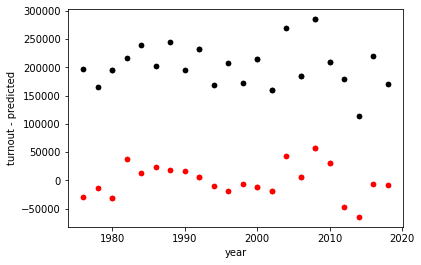

In [182]:
plotting_subset = elec_df[(elec_df['state']=='CALIFORNIA') & (elec_df['district'] == 8)]

ax1 = plotting_subset.plot.scatter(x='year', y='totalturnout', color='black')
ax2 = plotting_subset.plot.scatter(x='year', y='turnout - predicted', color='red', ax=ax1)

# Analysis

\begin{equation} \text{turnout - expected}_{it} = Drought_{it} + ... \end{equation}

\begin{equation} D_{\text{incumbent lost}, it} = Drought_{it} + ...  \end{equation}

\begin{equation} \text{R vote share}_{it} = Drought_{it} + ... \end{equation}

